In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append("C:/Users/qq651/OneDrive/Codes/")
sys.path.append("C:/Users/qq651/OneDrive/Codes/A2project")
import illustris_python as il
import matplotlib.pyplot as plt
from plotTools.plot import *
import illustrisAPI as iapi

In [2]:
rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0])
il1_snap = [135, 120, 108, 95, 85, 75, 68, 64, 60]
tng_snap = [99, 84, 67, 59, 50, 40, 33, 29, 25]

il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy')
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy')

tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy')

In [3]:
tng_unbar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_unbar.append(i)

In [4]:
M=1000 #g
L=100 #cm
T=1 #s
V=100 #cms-1
tng = np.load('f:/Linux/localRUN/tngSimuData.npy', allow_pickle=True).item()
h = tng['h']
def e_const(snap, simuData):
    a = simuData['Redshifts'][snap, 2]
    # t = simuData['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / h
    return (1e10*1.989e30*M/h)*(a*3.086e+19*L/h)**2/((0.978*1e9*31556926*T/h)**2)

cons = {}
t = {}
for snap in tng_snap:
    cons[snap] = e_const(snap, tng)
    t[snap] = tng['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / h

In [5]:
il1 = np.load('f:/Linux/localRUN/il1SimuData.npy', allow_pickle=True).item()
def e_const(snap, simuData):
    h = simuData['h']
    a = simuData['Redshifts'][snap, 2]
    # t = simuData['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / h
    return (1e10*1.989e30*M/h)*(a*3.086e+19*L/h)**2/((0.978*1e9*31556926*T/h)**2)

il1_cons = {}
il1_t = {}
for snap in il1_snap:
    il1_cons[snap] = e_const(snap, il1)
    il1_t[snap] = il1['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / h

In [6]:
def logMasSun(data):
    if type(data) != type(np.array(0)):
        data = np.array(data)
    data = np.log10(data * 10 ** 10)
    data[np.isinf(data)] = 0
    return data

def logmass(data):
    if type(data) != type(np.array(0)):
        data = np.array(data)
    data = np.log10(data)
    data[np.isinf(data)] = 0
    data[np.isnan(data)] = 0
    return data

#Next block is BH kinematic energy plot
-------------------------------------------

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


(-0.1, 2)

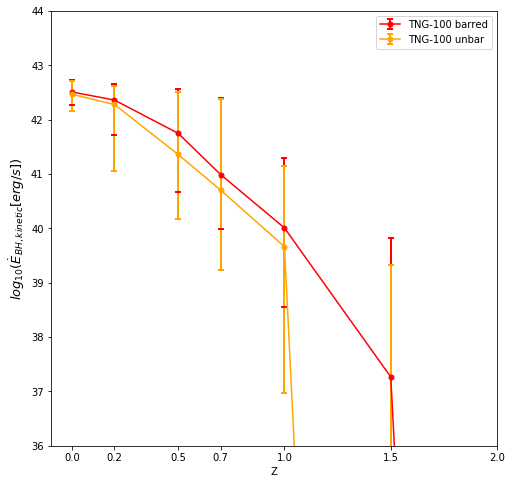

In [8]:
#get data
unbar_rawdata = []
bar_rawdata = []
for i in tng_snap:
    unbar_rawdata.append([])
    bar_rawdata.append([])

for subID in tng_diskID:
    isdata = 1
    prog = LoadMergHist('TNG', subID)[0]
    tmp = []
    last = 0
    t_last = 0
    for snap in tng_snap[::-1]:
        try:
            haloID = prog[snap]
            f = h5py.File('f:/Linux/TNG_cutoff/bhs/snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')

            engy = np.array(f['PartType5']['BH_CumEgyInjection_RM']).sum() * cons[snap] - last
            last = np.array(f['PartType5']['BH_CumEgyInjection_RM']).sum() * cons[snap]
            delta_t = t[snap] - t_last
            t_last = t[snap]
        except:
            isdata = 0
            break
        tmp.append(engy / delta_t)
    if isdata:
        if subID in tng_barID:
            for i in range(len(tmp)):
                bar_rawdata[i].append(tmp[len(tmp)-1-i])
        else:
            for i in range(len(tmp)):
                unbar_rawdata[i].append(tmp[len(tmp)-1-i])

#plot
bar_rawdata = logmass(bar_rawdata)
unbar_rawdata = logmass(unbar_rawdata)

ydata, err = Y_rawdata(bar_rawdata, len(tng_snap))
ydata2, err2 = Y_rawdata(unbar_rawdata, len(tng_snap))


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'$log_{10}(\dot{E}_{BH,kinetic}[erg/s])$', fontsize=13)
# ax.set_yscale("log")
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(36, 44)
ax.set_xticks(rs)
# ax.set_title("Galaxies(subhalo) dark matter mass")

#lines
ax.errorbar(rs, ydata, yerr=err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
ax.errorbar(rs, ydata2, yerr=err2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-', label='TNG-100 unbar')
ax.legend(loc = 0)
ax.set_xlim(-0.1, 2)
# plt.savefig('f:/Linux/local_result/E_kinetic.pdf')

In [7]:
def Y_rawdata(data, snapnum):
    plotdata = [[], [], []]
    for i in range(snapnum):
        d0, d1, d2 = ErrorBarMedian(data[i, :])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1, :], Err

def getData(simu, snapList, fields, haloType='sub'):
    raw = {}
    for snap in snapList:
        if haloType == 'fof':
            tmp = il.func.loadhalos(simu, snap, fields)
        else:
            tmp = il.func.loadSubhalos(simu, snap, fields)
        raw[snap] = tmp
    return raw

#next block is BH particles feedback energy(thermal)  plot
-------------------------------------------

In [10]:
#get data
unbar_rawdata = []
bar_rawdata = []
unbar_il1 = []
bar_il1 = []
for i in tng_snap:
    unbar_rawdata.append([])
    bar_rawdata.append([])
    bar_il1.append([])
    unbar_il1.append([])


for subID in tng_diskID:
    isdata = 1
    prog = LoadMergHist('TNG', subID)[0]
    tmp = []
    last = 0
    t_last = 0
    for snap in tng_snap[::-1]:
        try:
            haloID = prog[snap]
            f = h5py.File('f:/Linux/TNG_cutoff/bhs/snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')

            engy = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * cons[snap] - last
            last = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * cons[snap]
            delta_t = t[snap] - t_last
            t_last = t[snap]
        except:
            isdata = 0
            break
        tmp.append(engy / delta_t)
    if isdata:
        if subID in tng_barID:
            for i in range(len(tmp)):
                bar_rawdata[i].append(tmp[len(tmp)-1-i])
        else:
            for i in range(len(tmp)):
                unbar_rawdata[i].append(tmp[len(tmp)-1-i])

for subID in il1_diskID:
    isdata = 1
    prog = LoadMergHist('il1', subID)[0]
    tmp = []
    last = 0
    t_last = 0
    for snap in il1_snap[::-1]:
        try:
            haloID = prog[snap]
            f = h5py.File('f:/Linux/il1_bh_cutoff/snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')

            engy = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * il1_cons[snap] - last
            last = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * il1_cons[snap]
            delta_t = il1_t[snap] - t_last
            t_last = il1_t[snap]
        except:
            isdata = 0
            break
        tmp.append(engy / delta_t)
    if isdata:
        if subID in il1_barID:
            for i in range(len(tmp)):
                bar_il1[i].append(tmp[len(tmp)-1-i])
        else:
            for i in range(len(tmp)):
                unbar_il1[i].append(tmp[len(tmp)-1-i])


In [11]:
#plot data
bar_rawdata = logmass(bar_rawdata)
unbar_rawdata = logmass(unbar_rawdata)
bar_il1 = logmass(bar_il1)
unbar_il1 = logmass(unbar_il1)

ydata, err = Y_rawdata(bar_rawdata, len(tng_snap))
ydata2, err2 = Y_rawdata(unbar_rawdata, len(tng_snap))

ydata_il1, err_il1 = Y_rawdata(bar_il1, len(il1_snap))
ydata2_il1, err2_il1 = Y_rawdata(unbar_il1, len(il1_snap))


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


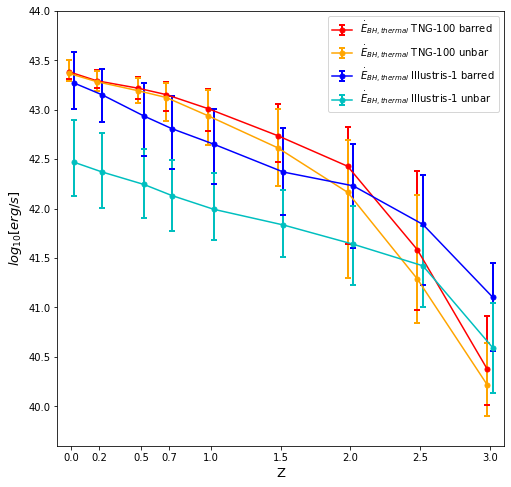

In [12]:
#plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Z', fontsize=13)
ax.set_ylabel(r'$log_{10}[erg/s]$', fontsize=13)
# ax.set_yscale("log")
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(39.6, 44)
ax.set_xticks(rs)
# ax.set_title("subhalo BH particle feedback thermal energy")

#lines
ax.errorbar(rs-0.02, ydata, yerr=err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label=r'$\dot{E}_{BH,thermal}$ TNG-100 barred')
ax.errorbar(rs-0.02, ydata2, yerr=err2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-', label=r'$\dot{E}_{BH,thermal}$ TNG-100 unbar')

ax.errorbar(rs+0.02, ydata_il1, yerr=err_il1, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o',ms=5, ls='-', label=r'$\dot{E}_{BH,thermal}$ Illustris-1 barred')
ax.errorbar(rs+0.02, ydata2_il1, yerr=err2_il1, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o',ms=5, ls='-', label=r'$\dot{E}_{BH,thermal}$ Illustris-1 unbar')

ax.legend(loc = 0)
# ax.set_xlim(-0.1, 2)
# plt.savefig('f:/Linux/local_result/BH/E_thermal.pdf')

In [13]:
unbar_il1

array([[41.07028384, 41.09863728, 41.13627298, ..., 44.22713467,
        44.44645506,         nan],
       [40.9660365 , 41.00198717, 41.01230542, ..., 43.96237555,
        44.06865656, 44.32516967],
       [40.88036543, 40.90011352, 40.95020439, ..., 43.91558567,
        44.15213348,         nan],
       ...,
       [39.76394489, 39.94198466, 40.01644792, ..., 43.59712177,
        43.79548621,         nan],
       [38.8812904 , 38.99212548, 39.44906115, ..., 43.33451311,
        43.42201303, 43.72961357],
       [36.88271483, 37.44476648, 37.45569662, ..., 42.69126911,
        42.70239969, 42.95019278]])

#next block mix upper two fig
-------------------------------------------

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


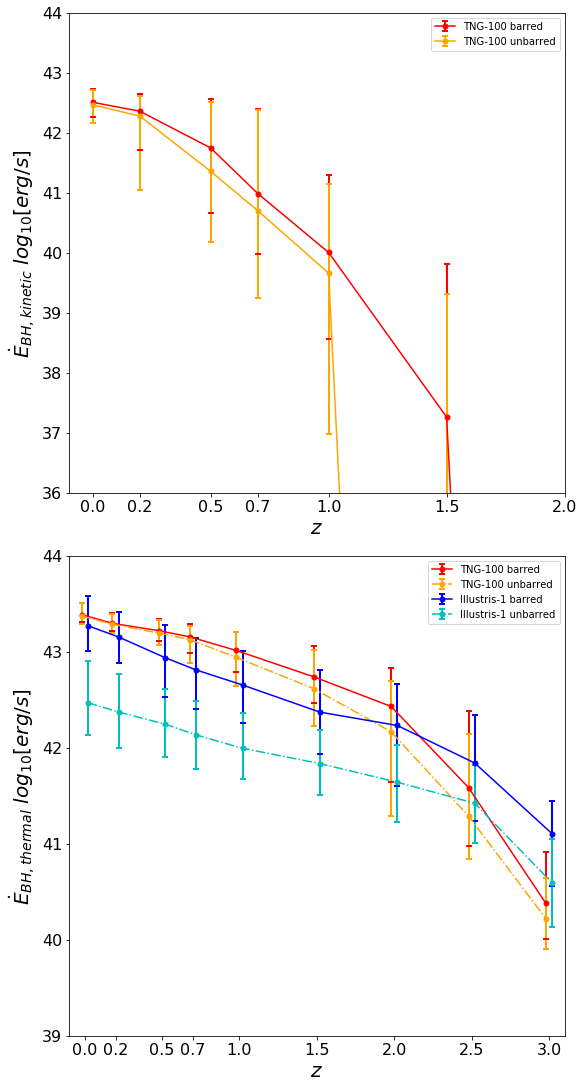

In [8]:
fig = plt.figure(figsize=(8,15), constrained_layout=True)
gs = plt.GridSpec(4,4, figure=fig)

ax1 = fig.add_subplot(gs[0:2, :])
ax2 = fig.add_subplot(gs[2:4, :])
ax = [ax1, ax2]


#-----------------TNG kinetic------------------

#---------------------------------plot data-------------------------------
unbar_rawdata = []
bar_rawdata = []
for i in tng_snap:
    unbar_rawdata.append([])
    bar_rawdata.append([])

for subID in tng_diskID:
    isdata = 1
    prog = LoadMergHist('TNG', subID)[0]
    tmp = []
    last = 0
    t_last = 0
    for snap in tng_snap[::-1]:
        try:
            haloID = prog[snap]
            f = h5py.File('f:/Linux/TNG_cutoff/bhs/snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')

            engy = np.array(f['PartType5']['BH_CumEgyInjection_RM']).sum() * cons[snap] - last
            last = np.array(f['PartType5']['BH_CumEgyInjection_RM']).sum() * cons[snap]
            delta_t = t[snap] - t_last
            t_last = t[snap]
        except:
            isdata = 0
            break
        tmp.append(engy / delta_t)
    if isdata:
        if subID in tng_barID:
            for i in range(len(tmp)):
                bar_rawdata[i].append(tmp[len(tmp)-1-i])
        else:
            for i in range(len(tmp)):
                unbar_rawdata[i].append(tmp[len(tmp)-1-i])

#plot
bar_rawdata = logmass(bar_rawdata)
unbar_rawdata = logmass(unbar_rawdata)

ydata, err = Y_rawdata(bar_rawdata, len(tng_snap))
ydata2, err2 = Y_rawdata(unbar_rawdata, len(tng_snap))
#---------------------------------plot data-------------------------------
ax[0].set_xlabel('$z$', fontsize=20)
ax[0].set_ylabel(r'$\dot{E}_{BH,kinetic}$ $log_{10}[erg/s]$', fontsize=20)
# ax.set_yscale("log")
ax[0].set_xlim(-0.1, 2.1)
ax[0].set_ylim(36, 44)
ax[0].set_xticks(rs)
# ax[0].set_title(r'$\dot{E}_{BH,kinetic}$', fontsize=20)

#lines
ax[0].tick_params(labelsize=16)
ax[0].errorbar(rs, ydata, yerr=err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
ax[0].errorbar(rs, ydata2, yerr=err2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-', label='TNG-100 unbarred')
ax[0].legend(loc = 0)
ax[0].set_xlim(-0.1, 2.0)


#-----------------TNG &IL1 thermal------------------

#---------------------------------plot data-------------------------------
unbar_rawdata = []
bar_rawdata = []
unbar_il1 = []
bar_il1 = []
for i in tng_snap:
    unbar_rawdata.append([])
    bar_rawdata.append([])
    bar_il1.append([])
    unbar_il1.append([])


for subID in tng_diskID:
    isdata = 1
    prog = LoadMergHist('TNG', subID)[0]
    tmp = []
    last = 0
    t_last = 0
    for snap in tng_snap[::-1]:
        try:
            haloID = prog[snap]
            f = h5py.File('f:/Linux/TNG_cutoff/bhs/snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')

            engy = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * cons[snap] - last
            last = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * cons[snap]
            delta_t = t[snap] - t_last
            t_last = t[snap]
        except:
            isdata = 0
            break
        tmp.append(engy / delta_t)
    if isdata:
        if subID in tng_barID:
            for i in range(len(tmp)):
                bar_rawdata[i].append(tmp[len(tmp)-1-i])
        else:
            for i in range(len(tmp)):
                unbar_rawdata[i].append(tmp[len(tmp)-1-i])

for subID in il1_diskID:
    isdata = 1
    prog = LoadMergHist('il1', subID)[0]
    tmp = []
    last = 0
    t_last = 0
    for snap in il1_snap[::-1]:
        try:
            haloID = prog[snap]
            f = h5py.File('f:/Linux/il1_bh_cutoff/snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')

            engy = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * il1_cons[snap] - last
            last = np.array(f['PartType5']['BH_CumEgyInjection_QM']).sum() * il1_cons[snap]
            delta_t = il1_t[snap] - t_last
            t_last = il1_t[snap]
        except:
            isdata = 0
            break
        tmp.append(engy / delta_t)
    if isdata:
        if subID in il1_barID:
            for i in range(len(tmp)):
                bar_il1[i].append(tmp[len(tmp)-1-i])
        else:
            for i in range(len(tmp)):
                unbar_il1[i].append(tmp[len(tmp)-1-i])

bar_rawdata = logmass(bar_rawdata)
unbar_rawdata = logmass(unbar_rawdata)
bar_il1 = logmass(bar_il1)
unbar_il1 = logmass(unbar_il1)

ydata, err = Y_rawdata(bar_rawdata, len(tng_snap))
ydata2, err2 = Y_rawdata(unbar_rawdata, len(tng_snap))

ydata_il1, err_il1 = Y_rawdata(bar_il1, len(il1_snap))
ydata2_il1, err2_il1 = Y_rawdata(unbar_il1, len(il1_snap))
#----------------------------------plot data--------------------------------

ax[1].set_xlabel('$z$', fontsize=20)
ax[1].set_ylabel(r'$\dot{E}_{BH,thermal}$ $log_{10}[erg/s]$', fontsize=20)
# ax.set_yscale("log")
ax[1].set_xlim(-0.1, 3.1)
ax[1].set_ylim(39, 44)
ax[1].set_xticks(rs)
# ax.set_title("subhalo BH particle feedback thermal energy")

#lines
ax[1].errorbar(rs-0.02, ydata, yerr=err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label=r'TNG-100 barred')
ax[1].errorbar(rs-0.02, ydata2, yerr=err2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-.', label=r'TNG-100 unbarred')

ax[1].errorbar(rs+0.02, ydata_il1, yerr=err_il1, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o',ms=5, ls='-', label=r'Illustris-1 barred')
ax[1].errorbar(rs+0.02, ydata2_il1, yerr=err2_il1, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o',ms=5, ls='-.', label=r'Illustris-1 unbarred')

ax[1].tick_params(labelsize=16)
# ax[1].set_title(r'$\dot{E}_{BH,thermal}$', fontsize=20)
ax[1].legend(loc = 0)

plt.savefig('f:/Linux/local_result/BH/E_kine&thrm.pdf')